In [ ]:
!unzip /content/drive/MyDrive/covid_dataset.zip -d /content/drive/MyDrive

In [88]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from keras.models import Sequential
import numpy as np
from glob import glob
from matplotlib import pyplot as plt

from keras.models import load_model
import os

from tf_explain.core.grad_cam import GradCAM
from keras.utils import img_to_array, load_img
import cv2

import tensorflow as tf

In [8]:
IMAGE_SIZE = [224, 224] 

train_path = '../Covid19-dataset/train'
valid_path = '../Covid19-dataset/test'

In [5]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg.layers:
  layer.trainable=False

In [ ]:
folders=glob( '../input/covid19-image-dataset/Covid19-dataset/train/*')

In [4]:
x=Flatten()(vgg.output)

prediction=Dense(len(folders),activation='softmax')(x)


model = Model(inputs=vgg.input, outputs=prediction)


NameError: name 'vgg' is not defined

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [16]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('../Covid19-dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')


Found 251 images belonging to 3 classes.


In [61]:
test_set = test_datagen.flow_from_directory('../Covid19-dataset/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 66 images belonging to 3 classes.


In [25]:
from keras.models import load_model

model = load_model('covid_vgg1.h5')

In [28]:
test_loss, test_accuracy = model.evaluate(test_set)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

3/3 [==============================] - 22s 6s/step - loss: 0.0872 - accuracy: 0.9697
Test Loss: 0.08715351670980453, Test Accuracy: 0.9696969985961914


In [16]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [140]:
from tf_explain.core.grad_cam import GradCAM
from keras.utils import img_to_array, load_img
import cv2

In [141]:
model = load_model('covid_vgg1.h5')

In [142]:
def overlay_heatmap(img, heatmap):
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    return superimposed_img

In [174]:
def gradcam(pathname, outputfilename, layer_name):
    img_path = pathname
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    class_idx = np.argmax(preds[0])

    explainer = GradCAM()
    grid = explainer.explain((x, None), model, class_idx, layer_name=layer_name)

    orig_img = cv2.imread(pathname)
    superimposed_img = overlay_heatmap(orig_img, grid)
    cv2.imwrite(outputfilename, superimposed_img)

In [173]:
input_directory = '../Covid19-dataset/train/covid/'
output_directory = '../Output_Images/'
images_to_process = 5

# Keep track of the number of images processed
num_images_processed = 0

# Iterate over all image files in the directory
for i, filename in enumerate(os.listdir(input_directory)):
    # Create a new directory for each image
    image_directory = os.path.join(output_directory, f"image_{i+1}")
    os.makedirs(image_directory, exist_ok=True)
    
    for layer in model.layers:
        if 'conv' in layer.name or 'pool' in layer.name:
            name, extension = os.path.splitext(filename)
            gradcam(
                os.path.join(input_directory, filename), 
                os.path.join(image_directory, str(layer.name) + extension), 
                str(layer.name))

    # Save the original image in the new directory
    root_name, extension = os.path.splitext(filename)
    cv2.imwrite(os.path.join(image_directory, '_original' + extension), cv2.imread(os.path.join(input_directory, filename)))
    
    num_images_processed += 1
    
    # Check if we have processed the desired number of images
    if num_images_processed == images_to_process:
        break

block1_conv1
1/1 [==============================] - 0s 467ms/step
block1_conv2
1/1 [==============================] - 0s 354ms/step
block1_pool
1/1 [==============================] - 0s 376ms/step
block2_conv1
1/1 [==============================] - 0s 376ms/step
block2_conv2
1/1 [==============================] - 0s 343ms/step
block2_pool
1/1 [==============================] - 0s 369ms/step
block3_conv1
1/1 [==============================] - 0s 312ms/step
block3_conv2
1/1 [==============================] - 0s 329ms/step
block3_conv3
1/1 [==============================] - 0s 306ms/step
block3_pool
1/1 [==============================] - 0s 351ms/step
block4_conv1
1/1 [==============================] - 0s 332ms/step
block4_conv2
1/1 [==============================] - 0s 387ms/step
block4_conv3
1/1 [==============================] - 0s 430ms/step
block4_pool
1/1 [==============================] - 0s 331ms/step
block5_conv1
1/1 [==============================] - 0s 373ms/step
block5_conv2
1

In [177]:
import os
from PIL import Image, ImageDraw, ImageFont

def stitch_images(folder_path, grid_shape=(5, 4), image_size=(140, 140), padding=20, outer_padding=20, label_height=40, font_size=10):
    grid_width, grid_height = grid_shape
    img_width, img_height = image_size

    canvas_width = grid_width * img_width + (grid_width - 1) * padding + 2 * outer_padding
    canvas_height = grid_height * (img_height + label_height) + (grid_height - 1) * padding + 2 * outer_padding

    canvas = Image.new("RGB", (canvas_width, canvas_height), (255, 255, 255))
    draw = ImageDraw.Draw(canvas)
    font = ImageFont.truetype("arial.ttf", font_size)

    image_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path)
                         if os.path.isfile(os.path.join(folder_path, f))
                         and f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif'))])

    for index, image_path in enumerate(image_files):
        img = Image.open(image_path)
        img = img.resize(image_size, Image.LANCZOS)

        x = outer_padding + (index % grid_width) * (img_width + padding)
        y = outer_padding + (index // grid_width) * (img_height + label_height + padding)

        canvas.paste(img, (x, y))

        label = os.path.splitext(os.path.basename(image_path))[0]
        label_width, label_height_actual = draw.textsize(label, font=font)
        label_x = x + (img_width - label_width) // 2
        label_y = y + img_height

        draw.text((label_x, label_y), label, font=font, fill=(0, 0, 0))

    return canvas

# Path to the folder containing the subfolders
parent_folder_path = '../Output_Images/'

# Iterate through the subfolders in the parent folder
for folder_name in os.listdir(parent_folder_path):
    folder_path = os.path.join(parent_folder_path, folder_name)
    
    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Stitch images together in a 5x4 grid
        stitched_image = stitch_images(folder_path)

        # Save the stitched image with the folder name as the file name in the "Output_Images" folder
        stitched_image.save(os.path.join(parent_folder_path, f"{folder_name}_stitched_image.jpg"))


C:\Users\joshm\AppData\Local\Temp\ipykernel_66912\1769122650.py:29: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_width, label_height_actual = draw.textsize(label, font=font)
C:\Users\joshm\AppData\Local\Temp\ipykernel_66912\1769122650.py:29: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_width, label_height_actual = draw.textsize(label, font=font)
C:\Users\joshm\AppData\Local\Temp\ipykernel_66912\1769122650.py:29: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_width, label_height_actual = draw.textsize(label, font=font)
C:\Users\joshm\AppData\Local\Temp\ipykernel_66912\1769122650.py:29: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_width, la

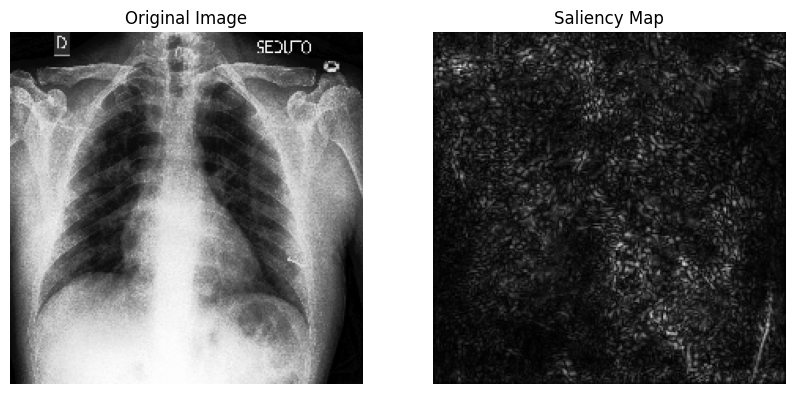

In [11]:
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def visualize_saliency_map(model, image_path):
    img = preprocess_image(image_path)
    img_tensor = tf.convert_to_tensor(img)  # Convert the NumPy array to a TensorFlow tensor
    
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        loss = tf.keras.backend.max(predictions, axis=1)
    
    gradients = tape.gradient(loss, img_tensor)
    saliency_map = np.max(np.abs(gradients.numpy()), axis=-1)[0]

    # Normalize the saliency map
    saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map))

    # Visualize the original image and the saliency map
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img[0])
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map, cmap='gray')
    plt.title('Saliency Map')
    plt.axis('off')

    plt.show()


# Replace 'path/to/image.jpg' with the path to the image you'd like to visualize
image_path = '../Covid19-dataset/train/covid/01.jpeg'
visualize_saliency_map(model, image_path)


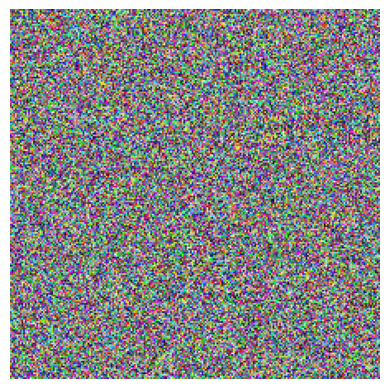

In [13]:
def deprocess_image(x):
    x = x.reshape((x.shape[1], x.shape[2], x.shape[3]))
    x[..., 0] += 103.939
    x[..., 1] += 116.779
    x[..., 2] += 123.68
    x = x[..., ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

def generate_appearance_model(model, target_class, iterations=200, step=1, input_shape=(224, 224, 3)):
    input_image = tf.random.uniform((1, *input_shape), 0, 255)
    input_image = tf.Variable(preprocess_input(input_image))

    for _ in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(input_image)
            predictions = model(input_image)
            loss = -predictions[0][target_class]

        gradients = tape.gradient(loss, input_image)
        gradients /= tf.maximum(tf.reduce_mean(tf.abs(gradients)), 1e-6)
        input_image.assign_add(gradients * step)

    optimized_image = deprocess_image(input_image.numpy())
    return optimized_image

target_class = 0  # Change this to the class index you want to visualize
appearance_model = generate_appearance_model(model, target_class)

plt.imshow(appearance_model)
plt.axis('off')
plt.show()




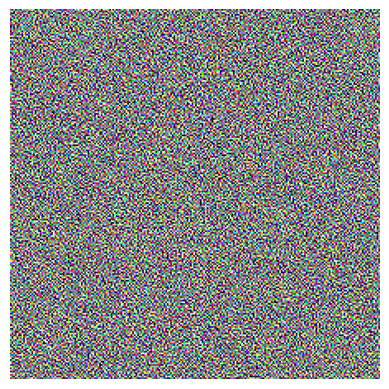

In [16]:
def generate_appearance_model(model, target_class, iterations=200, step=1, input_shape=(224, 224, 3), tv_weight=1e-4):
    def total_variation(x):
        a = tf.square(x[:, :-1, :-1, :] - x[:, 1:, :-1, :])
        b = tf.square(x[:, :-1, :-1, :] - x[:, :-1, 1:, :])
        return tf.reduce_sum(tf.sqrt(a + b + 1e-5))

    input_image = tf.random.uniform((1, *input_shape), 0, 255)
    input_image = tf.Variable(preprocess_input(input_image))

    for _ in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(input_image)
            predictions = model(input_image)
            loss = -predictions[0][target_class] + tv_weight * total_variation(input_image)

        gradients = tape.gradient(loss, input_image)
        gradients /= tf.maximum(tf.reduce_mean(tf.abs(gradients)), 1e-6)
        input_image.assign_add(gradients * step)

    optimized_image = deprocess_image(input_image.numpy())
    return optimized_image

target_class = 1  # Change this to the class index you want to visualize
appearance_model = generate_appearance_model(model, target_class)

plt.imshow(appearance_model)
plt.axis('off')
plt.show()
